In [118]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [119]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/sng_combined.json')

In [120]:
for source, node in graph._node.items():

    if node['type'] == 'city':

        node['type'] = 'destination'

graph = nx.to_directed(graph)

deep_reload(src)

criteria = [
    lambda e: e['distance'] <= 550e3,
    lambda e: e['distance'] >= 10e3,
]

graph = src.graph.remove_edges(graph, criteria)

In [121]:
src.graph.graph_to_json(graph, 'Outputs/sng_combined_directed.json')

In [122]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/sng_combined_directed.json')

In [10]:
deep_reload(src)

destinations = [k for k, v in graph._node.items() if v['type'] == 'destination']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

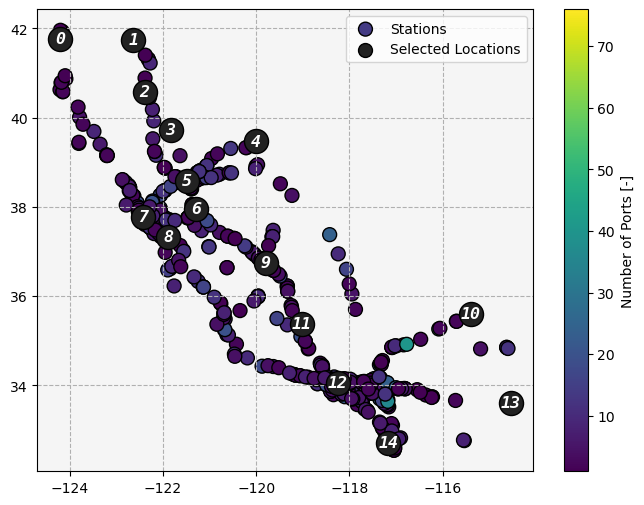

In [11]:
fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 100,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        # 'ticks': list(range(1, 16)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#222222',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(destinations, ax = ax, **kw)

x = [n['x'] for n in destinations._node.values()]
y = [n['y'] for n in destinations._node.values()]
n = [f'{n}' for n in range(destinations.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontweight': 'bold',
    'fontfamily': 'monospace',
    'color': '#ffffff'
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

_ = ax.set(**{
    # 'xticks': np.linspace(-5e5, 5e5, 11),
    # 'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    # 'xlim': (-5e5, 5e5),
    # 'yticks': np.linspace(-5e5, 5e5, 11),
    # 'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    # 'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

In [12]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
# seed = None
rng = np.random.default_rng(seed)

risk_attitude = (0, .2)
risk_attitude = (.8, 1)
rho = np.linspace(*risk_attitude, 100)

cases = 30

station_kw = {}

station_kw['destination'] = {
    'cases': 1,
    'type': 'ac',
    'access': 'private',
    'price': .4 / 3.6e6,
    'setup_time': 0,
    'rng': rng,
}

station_kw['station'] = {
    'reliability': .5,
    'cases': cases,
    'type': 'dc',
    'access': 'public',
    'power': src.routing._network_power,
    'price': .5 / 3.6e6,
    'setup_time': 300,
    'rng': rng,
}

vehicle_kw = {
    'cases': 1,
    'linear_fraction': .8,
    'risk_attitude': (0, 1),
}

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

In [13]:
deep_reload(src)

destinations = [k for k, v in graph._node.items() if v['type'] == 'destination']
origins = ['Los Angeles']

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, origins, objective = vehicle, destinations = destinations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.8398 seconds


In [14]:
pprint({k: (v['total_time'].mean() / 3600, v['driving_time'].mean() / 3600) for k, v in values.items()})

{'Bakersfield': (1.7092187153124685, 1.7092187153124685),
 'Chico': (8.923272143016808, 7.277269459706965),
 'Crescent City': (13.955337224458368, 11.426237831612836),
 'Fresno': (3.263417207792208, 3.263417207792208),
 'I-10 to Phoenix (State Line)': (3.4103952297702254, 3.4103952297702254),
 'I-15 to Las Vegas (State Line)': (3.497081390831393, 3.497081390831393),
 'I-80 to Reno (State Line)': (9.371729102723775, 7.636809752747264),
 'Los Angeles': (0.0, 0.0),
 'Redding': (10.040043295700464, 8.165521423021435),
 'Sacramento': (7.102534229358168, 5.732208208458209),
 'San Diego': (2.0048143523143547, 2.0048143523143547),
 'San Francisco': (7.129552294626234, 5.764802662615164),
 'San Jose': (6.518531596779244, 5.287308288933289),
 'Stockton': (6.2483827092084825, 5.026918081918081),
 'Yreka': (11.916131255548938, 9.657266015234766)}


In [15]:
pprint({k: (v['total_time'] / 3600, v['driving_time'] / 3600) for k, v in values.items()})

{'Bakersfield': (array([1.70921872]), array([1.70921872])),
 'Chico': (array([8.92327214]), array([7.27726946])),
 'Crescent City': (array([13.95533722]), array([11.42623783])),
 'Fresno': (array([3.26341721]), array([3.26341721])),
 'I-10 to Phoenix (State Line)': (array([3.41039523]), array([3.41039523])),
 'I-15 to Las Vegas (State Line)': (array([3.49708139]), array([3.49708139])),
 'I-80 to Reno (State Line)': (array([9.3717291]), array([7.63680975])),
 'Los Angeles': (array([0.]), array([0.])),
 'Redding': (array([10.0400433]), array([8.16552142])),
 'Sacramento': (array([7.10253423]), array([5.73220821])),
 'San Diego': (array([2.00481435]), array([2.00481435])),
 'San Francisco': (array([7.12955229]), array([5.76480266])),
 'San Jose': (array([6.5185316]), array([5.28730829])),
 'Stockton': (array([6.24838271]), array([5.02691808])),
 'Yreka': (array([11.91613126]), array([9.65726602]))}


In [16]:
deep_reload(src)

origins = [k for k, v in graph._node.items() if v['type'] == 'destination']

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    graph, origins, objective = vehicle,
)

print(f'\n\nExecuted in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 1.25 it/s, 12.81 s elapsed, 0.00 s remaining

Executed in 12.8084 seconds


In [17]:
cities = src.graph.graph_from_json('../charger_network_analysis/cities.json')

pop_adj = sum([v['population'] for v in cities._node.values()]) / cities.number_of_nodes()

weighted = {k: v['population'] / pop_adj for k, v in cities._node.items()}

In [18]:
src.routing.impedance(values, field = 'total_time') / 3600

6.361489308823682

In [19]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

4.810275666836245

In [123]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/sng_other_directed.json')

In [124]:
deep_reload(src)

seed = 1468952
seed = None
rng = np.random.default_rng(seed)

vehicle_param = src.experiments._vehicle_kwargs
station_param = src.experiments._station_kwargs
graphs = [0]

graph_index, vehicle_kw, station_kw = src.experiments.generate_case(
    graphs, vehicle_param, station_param, rng,
)

graph_index, vehicle_kw, station_kw

(0,
 {'capacity': 169367760.15164533,
  'power': 57259.013162413205,
  'risk_attitude': array([0.28097165, 0.48097165]),
  'cases': 1,
  'soc_bounds': (0.1, 1),
  'efficiency': 550,
  'linear_fraction': 0.8},
 {'destination': {'cases': 100,
   'type': 'ac',
   'access': 'private',
   'price': 1.1111111111111112e-07,
   'setup_time': 0,
   'rng': Generator(PCG64) at 0x7F47AA175E00},
  'station': {'reliability': 0.7631736333997164,
   'cases': 100,
   'type': 'dc',
   'access': 'public',
   'power': {'Tesla': [250000.0],
    'Electrify America': [150000.0],
    'ChargePoint Network': [62500.0],
    'eVgo Network': [50000.0, 100000.0, 350000.0],
    'default': [50000.0]},
   'price': 1.3888888888888888e-07,
   'setup_time': 300,
   'rng': Generator(PCG64) at 0x7F47AA175E00}})

In [144]:
vehicle_kw['risk_attitude'] = (.8, 1)
vehicle_kw['capacity'] = 40 * 3.6e6
station_kw['station']['reliability'] = .5 + .5

In [145]:
deep_reload(src)

costs, values, paths = src.experiments.run_case(
    graph, vehicle_kw, station_kw, method = 'dijkstra'
)

In [146]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

6.0812838724141045

In [147]:
src.routing.impedance(
    values, field = 'routing_time',
    origins = weighted,
    destinations = weighted,
) / 3600

6.0812838724141045

In [142]:
src.routing.impedance(
    values, field = 'total_time',
    origins = weighted,
    destinations = weighted,
) / 3600

7.704711236725918

In [143]:
src.routing.impedance(
    values, field = 'routing_time',
    origins = weighted,
    destinations = weighted,
) / 3600

6.101005247252591

In [114]:
graph._node['station_6'], graph._adj['station_6']

({'status': 0,
  'visited': 0,
  'x': -118.100471,
  'y': 33.861544,
  'n_dcfc': 3,
  'n_acl2': 2.0,
  'network': 'Non-Networked',
  'name': 'Cerritos Nissan',
  'address': '18707 Studebaker Rd',
  'city': 'Cerritos',
  'state': 'CA',
  'zip': '90703',
  'access_code': 'public',
  'status_code': 'E',
  'type': 'station',
  'roadnum': 'I605',
  'station': <src.routing.Station at 0x7f4739cc8cd0>},
 {'Fresno': {'time': 12897.393356643339,
   'distance': 379040.0,
   'price': 0,
   'type': 'to_destination',
   'feasible': True,
   'energy': 208472000.0,
   'charging_time': 4527.070083158706,
   'delay_time': 3603.792983516618,
   'total_time': 21028.25642331866,
   'routing_time': 18374.908489329275},
  'I-15 to Las Vegas (State Line)': {'time': 12716.52527472528,
   'distance': 370220.0,
   'price': 0,
   'type': 'to_destination',
   'feasible': True,
   'energy': 203621000.0,
   'charging_time': 4297.40379778444,
   'delay_time': 3603.792983516618,
   'total_time': 20617.722056026338,
  